In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import *
from tqdm import tqdm
from InsufficientGibbs.Models import NormalKnownScaleModel, LaplaceKnownScaleModel
from InsufficientGibbs.Distribution import Normal

In [2]:
def log_ratio_normal_laplace(X,mu):
    N = len(X)
    return -(N/2)*np.log(np.pi)+np.sqrt(2)*np.sum(np.abs(X-mu))-np.sum((X-mu)**2)/2

In [3]:
from scipy.optimize import fixed_point
from scipy.special import logsumexp

def func_r_paper(r,l1,l2,lstar):
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2):
    lstar = np.median(l1)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar),maxiter=10000)
    BF = r*np.exp(lstar)
    return BF


def func_logBF_paper(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_paper(l1,l2):
    logBF = fixed_point(func_logBF_paper,1,args=(l1,l2),maxiter=10000)
    return logBF

def func_BF_dumb(BF,l1,l2):
    num = np.sum(np.exp(l2)/(np.exp(l2)+BF))
    den = np.sum(1/(np.exp(l1)+BF))
    return num/den
def BF_dumb(l1,l2):
    BF = fixed_point(func_BF_dumb,1,args=(l1,l2),maxiter=10000)
    return BF

In [4]:
def Comparison(N,T):
    X_norm = np.random.normal(0,1,N)
    X_laplace = np.random.laplace(0,1/np.sqrt(2),N)
    Bridge = []
    for X in [X_norm,X_laplace]:
        med, MAD = np.median(X),median_abs_deviation(X)
        MCMC_norm = NormalKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=False)
        MCMC_laplace = LaplaceKnownScaleModel(Normal(0,2)).Gibbs_med_MAD(T//2,N,med,MAD,List_X = True,verbose=False)
        X_Normal,X_Laplace = np.array(MCMC_norm["X"][1:]),np.array(MCMC_laplace["X"][1:])
        mu_Normal, mu_Laplace= np.array(MCMC_norm["chains"]["loc"]),np.array(MCMC_laplace["chains"]["loc"])
        
        l1 = [log_ratio_normal_laplace(X,mu) for X,mu in zip(X_Normal,mu_Normal)]
        l2 = [log_ratio_normal_laplace(X,mu) for X,mu in zip(X_Laplace,mu_Laplace)]
        
        BF_bridge = BF_paper(l1,l2)

        Bridge.append(BF_bridge)
    return Bridge
    

In [5]:
N_list = [10,100,1000]
T = 10000

n_iter = 100

Normal_Bridge_N = []
Laplace_Bridge_N = []

for N in N_list:
    print("N = {}".format(N))
    res = [Comparison(N,T) for _ in tqdm(range(n_iter))]
    res = np.array(res)
    
    Normal_Bridge_N.append(res[:,0])
    Laplace_Bridge_N.append(res[:,1])

N = 10


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [1:02:32<00:00, 37.52s/it]


N = 100


100%|██████████| 100/100 [1:07:08<00:00, 40.28s/it]


N = 1000


100%|██████████| 100/100 [1:09:48<00:00, 41.88s/it]


# Figure

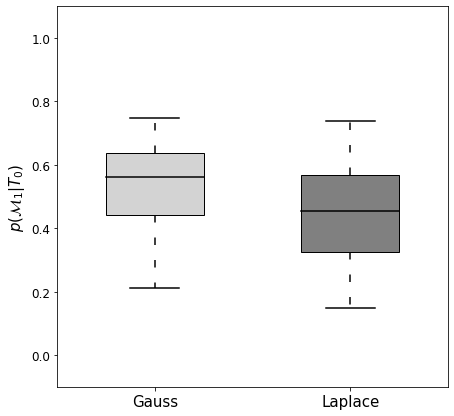

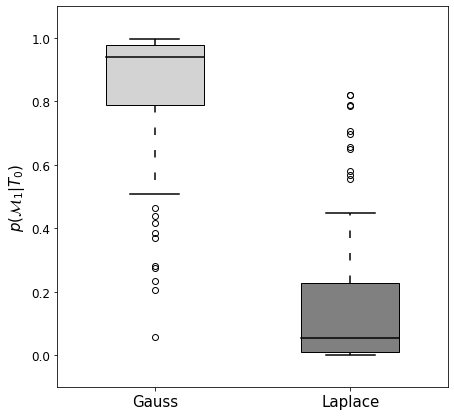

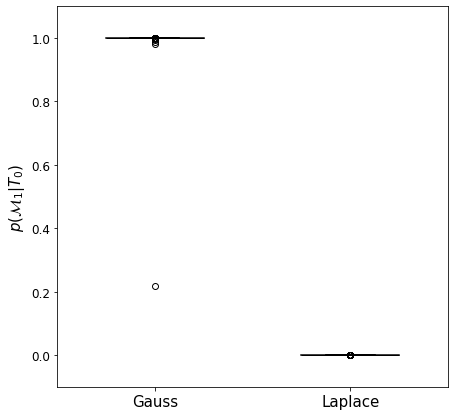

In [21]:

c1 = "black"
c2 = "lightgrey"
c3 = "darkgrey"
w = 0.5
for i,(bridge_norm, bridge_lp) in enumerate(zip(Normal_Bridge_N,Laplace_Bridge_N)):
    f = plt.figure(figsize=(7, 7))
    bplot=  plt.boxplot([bridge_norm/(1+bridge_norm), bridge_lp/(1+bridge_lp)], labels=["Gauss", "Laplace"], 
                        widths=w, patch_artist=True, showfliers=True,
                        whiskerprops=dict(color="black", linewidth=1.5, linestyle=(0, (5, 10))),
                        medianprops=dict(color="black", linewidth=1.5), 
                        capprops=dict(color="black", linewidth=1.5,));
    for patch, color in zip(bplot['boxes'], ["lightgrey", "grey"]):
        patch.set_facecolor(color)

    plt.ylabel("$p(\mathcal{M}_1|T_0)$", fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(-.1, 1.1)
    plt.yticks([0,.2,.4,.6,.8,1], fontsize=12)
    plt.savefig("Fig6{}.eps".format(['a','b','c'][i]), format = "eps", bbox_inches="tight")
    plt.savefig("Fig6{}.pdf".format(['a','b','c'][i]), format = "pdf", bbox_inches="tight")
    plt.show()
